##Behavioral Clustering & Engagement Patterns

In [29]:
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [7]:
df =pd.read_csv('normalized_steam.csv')
df.head()



,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [21]:
df.columns


Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price'],
      dtype='object')

### 1 .Creating features to help understand player behaviour

In [25]:

def create_behavioral_features(df):
    df = df.copy()

    # 1. Total Ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']

    # 2. Rating Ratio - what percentage of ratings are positive?
    df['rating_ratio'] = df['positive_ratings'] / (df['total_ratings'] + 1)
    # 3. Log-transformed playtime to handle extreme range
    df['playtime_engagement'] = np.log1p(df['average_playtime'])
    # 4. Playtime Consistency - how close is average to median playtime
    # If average = median, most players have similar playtimes
    df['playtime_consistency'] = df['average_playtime'] / (df['median_playtime'] + 1)

    # 5. Engagement Score - combines playtime and popularity
    df['engagement_score'] = (df['average_playtime'] * df['total_ratings']) / 1000

    # 6. Success Score - combines ratings, satisfaction and playtime
    df['success_score'] = (df['positive_ratings'] * df['rating_ratio'] * np.log1p(df['average_playtime']))

    return df

df_features = create_behavioral_features(df)
print("\n Our new features:")
print(df_features[['total_ratings', 'rating_ratio', 'engagement_score', 'success_score']].head())


 Our new features:
   total_ratings  rating_ratio  engagement_score  success_score
0         127873      0.973881       2252099.276   1.185693e+06
1           3951      0.839575          1094.427   1.567692e+04
2           3814      0.895413           713.218   1.601686e+04
3           1540      0.826087           397.320   5.843609e+03
4           5538      0.947825          3455.712   3.203476e+04


### 2. Selecting features that represent different behavioral dimensions

In [27]:

behavioral_features = [
    'average_playtime',      # how long people play
    'median_playtime',       # Typical player's playtime
    'positive_ratings',      # How many people like it
    'negative_ratings',      # How many people dislike it
    'rating_ratio',          # Overall satisfaction rate
    'engagement_score',      # Combined popularity + playtime
    'playtime_consistency',  # Playtime distribution among players
    'price',                 # Cost of the game
    'success_score'          # Overall success metric
]

# Create our feature matrix
X = df_features[behavioral_features].copy()
print(f"\nOur feature matrix has {X.shape[0]} games and {X.shape[1]} features")


Our feature matrix has 27075 games and 9 features


### 3.Scaling our features so tat they would contribute equally to our clusters

In [28]:


# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to our data and transform it
X_scaled = scaler.fit_transform(X)


### 4.Choosing Optimal Clusters and Performing Clustering

In [30]:

# Lists to store our results
inertia = []        # Measures how spread out clusters are (lower is better)
silhouette_scores = []  # Measures how well-separated clusters are (higher is better)
k_range = range(2, 10)  # Testing 2 through 9 clusters

print("\nTesting cluster counts:")
for k in k_range:
    # Create and fit K-means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Store the metrics
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

    print(f"  K={k}: Inertia = {kmeans.inertia_:.0f}, Silhouette = {silhouette_scores[-1]:.3f}")



Testing cluster counts:
  K=2: Inertia = 173074, Silhouette = 0.993
  K=3: Inertia = 138973, Silhouette = 0.984
  K=4: Inertia = 119805, Silhouette = 0.383
  K=5: Inertia = 95290, Silhouette = 0.385
  K=6: Inertia = 74696, Silhouette = 0.388
  K=7: Inertia = 63121, Silhouette = 0.438
  K=8: Inertia = 52389, Silhouette = 0.442
  K=9: Inertia = 44676, Silhouette = 0.442


#### Visualizing the Clusters

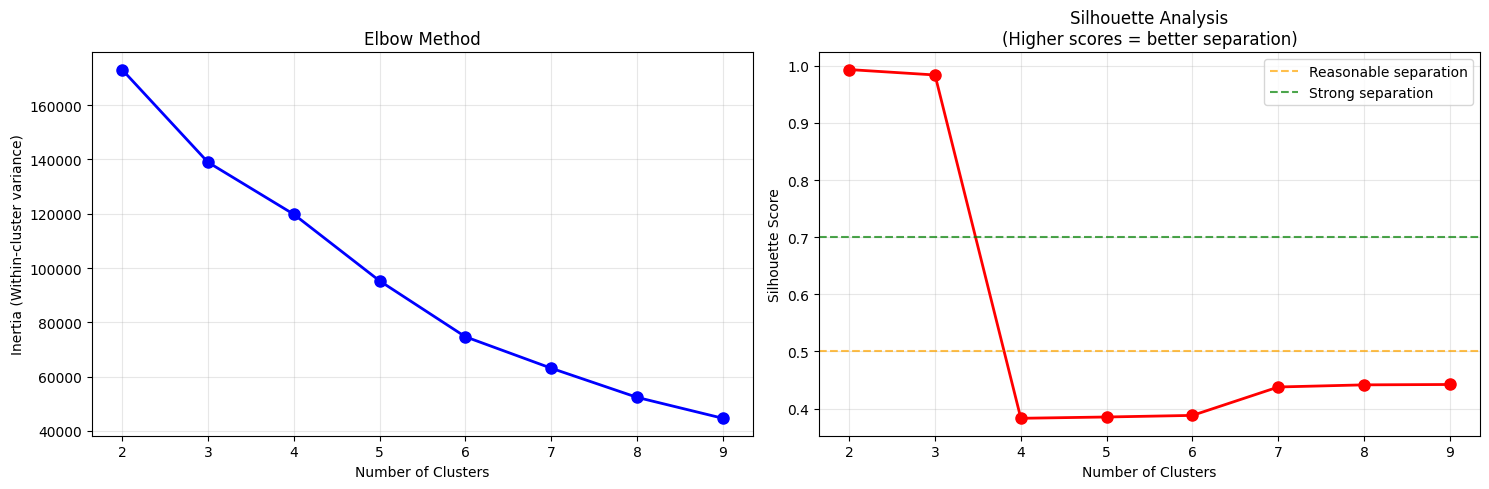

In [33]:
# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Elbow Method (Inertia)
ax1.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia (Within-cluster variance)')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# Plot 2: Silhouette Scores
ax2.plot(k_range, silhouette_scores, 'ro-', markersize=8, linewidth=2)
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis\n(Higher scores = better separation)')
ax2.grid(True, alpha=0.3)

# Add reference lines for silhouette interpretation
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Reasonable separation')
ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.7, label='Strong separation')
ax2.legend()

plt.tight_layout()
plt.show()


####Choosing the optimal clusters

In [41]:

# Find the best silhouette score
best_silhouette_idx = np.argmax(silhouette_scores)
best_k_silhouette = k_range[best_silhouette_idx]

print(f"Best silhouette score: {silhouette_scores[best_silhouette_idx]:.3f} at K={best_k_silhouette}")

# Finding the elbow
for i, k in enumerate(k_range):
    if i > 0:  # Skip the first one since we can't calculate improvement yet
        improvement = (inertia[i-1] - inertia[i]) / inertia[i-1] * 100
        print(f"  K={k}: Inertia = {inertia[i]:.0f} (Improvement: {improvement:.1f}% from K={k-1})")

# Choosing based on silhouette score and reasonable cluster count
print("\nCluster evaluation:")
for i, k in enumerate(k_range):
    sil_score = silhouette_scores[i]
    print(f"  K={k}: Silhouette = {sil_score:.3f} ")

if best_k_silhouette >= 4 and best_k_silhouette <= 6:
    optimal_clusters = best_k_silhouette
else:
    # If the best is outside reasonable range choose a middle ground
    optimal_clusters = 5

print(f"\nBased on our analysis, we choose K={optimal_clusters} clusters")

print(f"\nPerforming final clustering with {optimal_clusters} clusters")
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to our dataframe
df_features['behavior_cluster'] = cluster_labels

print(f"\nCluster distribution:")
cluster_counts = df_features['behavior_cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"  Cluster {cluster_id}: {count} games ({percentage:.1f}%)")

print(f"\nTotal games clustered: {len(df_features)}")

Best silhouette score: 0.993 at K=2
  K=3: Inertia = 138973 (Improvement: 19.7% from K=2)
  K=4: Inertia = 119805 (Improvement: 13.8% from K=3)
  K=5: Inertia = 95290 (Improvement: 20.5% from K=4)
  K=6: Inertia = 74696 (Improvement: 21.6% from K=5)
  K=7: Inertia = 63121 (Improvement: 15.5% from K=6)
  K=8: Inertia = 52389 (Improvement: 17.0% from K=7)
  K=9: Inertia = 44676 (Improvement: 14.7% from K=8)

Cluster evaluation:
  K=2: Silhouette = 0.993 
  K=3: Silhouette = 0.984 
  K=4: Silhouette = 0.383 
  K=5: Silhouette = 0.385 
  K=6: Silhouette = 0.388 
  K=7: Silhouette = 0.438 
  K=8: Silhouette = 0.442 
  K=9: Silhouette = 0.442 

Based on our analysis, we choose K=5 clusters

Performing final clustering with 5 clusters

Cluster distribution:
  Cluster 0: 17883 games (66.0%)
  Cluster 1: 1 games (0.0%)
  Cluster 2: 3 games (0.0%)
  Cluster 3: 1 games (0.0%)
  Cluster 4: 9187 games (33.9%)

Total games clustered: 27075
